# Reseting Models & repeated model simulations
Standard simulation scenarios for computational models are:
1. Repeated simulation under changed initial conditions
2. Repeated simulation under changed parameters & fixed initial conditions
3. Simulation of period of time, than change of parameters and continuation from the given concentrations

1.4.2; Compiler: gcc 4.8.4, C++ version: 199711; JIT Compiler: LLVM-3.4; Date: Jan 13 2016, 11:19:15
--------------------------------------------------------------------------------
<roadrunner.RoadRunner() { 
'this' : 0x3babc00
'modelLoaded' : true
'modelName' : test_3
'libSBMLVersion' : LibSBML Version: 5.11.0
'jacobianStepSize' : 1e-05
'conservedMoietyAnalysis' : false
'simulateOptions' : 
< roadrunner.SimulateOptions() 
{ 
'this' : 0x36ee1f0, 
'reset' : 0,
'structuredResult' : 0,
'copyResult' : 1,
'steps' : 50,
'start' : 0,
'duration' : 10
}>, 
'integrator' : 
< roadrunner.Integrator() >
  settings:
      relative_tolerance: 0.000001
      absolute_tolerance: 1.5624999999999998e-20
                   stiff: true
       maximum_bdf_order: 5
     maximum_adams_order: 12
       maximum_num_steps: 20000
       maximum_time_step: 0
       minimum_time_step: 0
       initial_time_step: 0
          multiple_steps: false
      variable_step_size: false

}>
---------------------------------

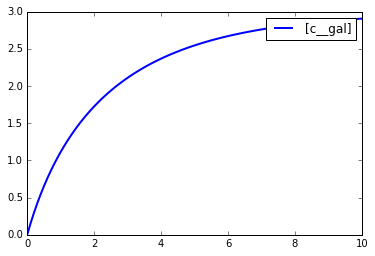

<type 'NamedArray'>


In [1]:
from __future__ import print_function
%matplotlib inline

# Simulating simple test model

import roadrunner
reload(roadrunner)  # make sure latest compiled version
print(roadrunner.__version__)


from simapp.models import CompModel
mtest = CompModel.objects.get(model_id="test_3")
r = roadrunner.RoadRunner(mtest.filepath)
# r = roadrunner.RoadRunner("test_3.xml")

# settings
absTol = 1E-6
relTol = 1E-6
absTol = absTol * min(r.model.getCompartmentVolumes())  # absTol relative to the amounts
integrator = r.getIntegrator()
integrator.setValue('stiff', True)
integrator.setValue('absolute_tolerance', absTol)
integrator.setValue('relative_tolerance', relTol)

# integrate
s = r.simulate(0,10, 100)
print('-'*80)
print(r)
print('-'*80)

# plot
r.plot()
print(type(s))
# print(s)  # [issue #257]

## Resetting values in the model
How to change parameters in the model and recalculate depending variables. This is needed for initializing SBML models in roadrunner with different parameters and volumes.

In [2]:
import numpy as np
from pandas import DataFrame
from roadrunner import SelectionRecord
# load model
r = roadrunner.RoadRunner("test_3.xml")
r.reset(SelectionRecord.ALL)  # full reset (parameters and concentrations)

def test_vec(r):
    return DataFrame({'x_cell': [r.x_cell, ], 
                      'Vol_c': [r.Vol_c, ], 
                      '[c__gal]': [r['[c__gal]'], ]})

# make a concentration backup (needed later)
concentration_backup = dict()
for sid in r.model.getFloatingSpeciesIds():
    concentration_backup[sid] = r["[{}]".format(sid)]

# initial state
print(test_vec(r)) 
assert(np.allclose([r.x_cell, r.Vol_c, r['[c__gal]']], 
                   [2.5e-05, 1.5625e-14, 0.00012]))

          Vol_c  [c__gal]    x_cell
0  1.562500e-14   0.00012  0.000025


In [3]:
# change parameter 
# -> the depending inital assignments are not updated (makes sense, are only initial)
r.x_cell = 10E-6  # [m]
print(test_vec(r))
assert(np.allclose([r.x_cell, r.Vol_c, r['[c__gal]']], 
                   [1.0e-05, 1.5625e-14, 0.00012]))

# reload resets(SelectionRecord.ALL)
r = roadrunner.RoadRunner("test_3.xml")
print(test_vec(r)) 
assert(np.allclose([r.x_cell, r.Vol_c, r['[c__gal]']], 
                   [2.5e-05, 1.5625e-14, 0.00012]))

# so do the change again
r.x_cell = 10E-6  # [m]
print(test_vec(r)) 
assert(np.allclose([r.x_cell, r.Vol_c, r['[c__gal]']], 
                   [1.0e-05, 1.5625e-14, 0.00012]))

          Vol_c  [c__gal]   x_cell
0  1.562500e-14   0.00012  0.00001
          Vol_c  [c__gal]    x_cell
0  1.562500e-14   0.00012  0.000025
          Vol_c  [c__gal]   x_cell
0  1.562500e-14   0.00012  0.00001


In [4]:
# force an update via recalculating depending assignments
# -> Volume is updated, but also the concentrations due to changes in volume !
from roadrunner import SelectionRecord
r.reset(SelectionRecord.INITIAL_GLOBAL_PARAMETER)
print(test_vec(r)) 
assert(np.allclose([r.x_cell, r.Vol_c, r['[c__gal]']], 
                   [1.0e-05, 1e-15, 0.001875]))

          Vol_c  [c__gal]   x_cell
0  1.000000e-15  0.001875  0.00001


In [5]:
# a reset of the initial concentrations does not bring the concentrations back
r.reset()  # only reset initial concentrations
print(test_vec(r)) 
assert(np.allclose([r.x_cell, r.Vol_c, r['[c__gal]']], 
                   [1.0e-05, 1e-15, 0.001875]))

r.reset(SelectionRecord.INITIAL_FLOATING_CONCENTRATION)  # only reset initial concentrations
print(test_vec(r)) 
assert(np.allclose([r.x_cell, r.Vol_c, r['[c__gal]']], 
                   [1.0e-05, 1e-15, 0.001875]))

# the backup of the concentrations is needed
# restore concentrations
# -> now same initial concentrations under changed parameters
for key, value in concentration_backup.iteritems():
    r.model['[{}]'.format(key)] = value
print(test_vec(r)) 
assert(np.allclose([r.x_cell, r.Vol_c, r['[c__gal]']], 
                   [1.0e-05, 1e-15, 0.00012]))

          Vol_c  [c__gal]   x_cell
0  1.000000e-15  0.001875  0.00001
          Vol_c  [c__gal]   x_cell
0  1.000000e-15  0.001875  0.00001
          Vol_c  [c__gal]   x_cell
0  1.000000e-15   0.00012  0.00001


In [6]:
# To reset all use
r.reset(SelectionRecord.ALL)  # full reset (parameters and concentrations)
print(test_vec(r)) 
assert(np.allclose([r.x_cell, r.Vol_c, r['[c__gal]']], 
                   [2.5e-05, 1.5625e-14, 0.00012]))

          Vol_c  [c__gal]    x_cell
0  1.562500e-14   0.00012  0.000025


## 1. Repeated simulation under changed initial conditions
Repeat the simulation with changing initial conditions

1.4.2; Compiler: gcc 4.8.4, C++ version: 199711; JIT Compiler: LLVM-3.4; Date: Jan 13 2016, 11:19:15
< roadrunner.Integrator() >
  settings:
      relative_tolerance: 0.000001
      absolute_tolerance: 1.5624999999999998e-20
                   stiff: true
       maximum_bdf_order: 5
     maximum_adams_order: 12
       maximum_num_steps: 20000
       maximum_time_step: 0
       minimum_time_step: 0
       initial_time_step: 0
          multiple_steps: false
      variable_step_size: true

['time', '[c__gal]', '[e__gal]']


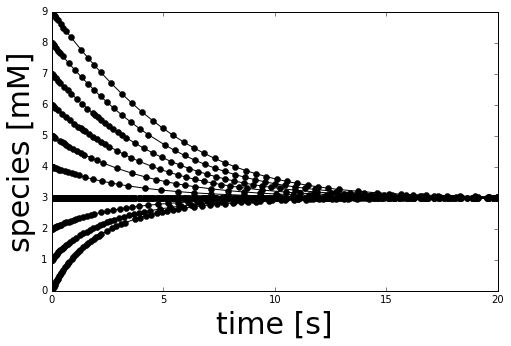

In [38]:
# load & reset model
%matplotlib inline
import roadrunner
from roadrunner import SelectionRecord
print(roadrunner.getVersionStr())

r = roadrunner.RoadRunner("test_3.xml")
r.reset(SelectionRecord.ALL)  # full reset, also happening in reload, but just to be sure

# simulation settings
absTol = 1E-6
relTol = 1E-6
# absTol relative to the amounts [fix for roadrunner issue #247]
absTol = absTol * min(r.model.getCompartmentVolumes())  
integrator = r.getIntegrator()

integrator.setSetting('stiff', True)
integrator.setSetting('absolute_tolerance', absTol)
integrator.setSetting('relative_tolerance', relTol)
integrator.setSetting('variable_step_size', True)
print(integrator)

# selection
r.selections = ['time'] + \
        ['[{}]'.format(sid) for sid in r.model.getFloatingSpeciesIds()] + \
        ['[{}]'.format(sid) for sid in r.model.getBoundarySpeciesIds()]
print(r.selections)
        
# simulation
tend = 20.0  # [s]
Nsim = 10    # number of repeats
results = []
for k in xrange(Nsim):
    # change initial concentration
    r['init([c__gal])'] = k
    # simulate
    s = r.simulate(0, tend)
    # store solution
    results.append(s)
    # reset the initial concentrations
    r.reset()

# plot the results
def plot_results(results):
    import matplotlib.pylab as plt
    plt_fontsize = 30
    plt.figure(figsize=(8,5))
    for s in results:
        plt.plot(s[:,0], s[:,1:], 'o-', color='black')
        # print('tend:', s[-1,0]) 
    
    plt.xlabel('time [s]', fontsize=plt_fontsize)
    plt.ylabel('species [mM]', fontsize=plt_fontsize)

plot_results(results)

## 2. Repeated simulation under changed parameters & fixed initial conditions
Now the more complex case of changing parameters & fixed initial conditions. 

In [39]:
# reset the model, the integration and simulate settings should still exist
print('-'*80)
print(r)
print('-'*80)

--------------------------------------------------------------------------------
<roadrunner.RoadRunner() { 
'this' : 0x4a5e980
'modelLoaded' : true
'modelName' : test_3
'libSBMLVersion' : LibSBML Version: 5.11.0
'jacobianStepSize' : 1e-05
'conservedMoietyAnalysis' : false
'simulateOptions' : 
< roadrunner.SimulateOptions() 
{ 
'this' : 0x4d00a80, 
'reset' : 0,
'structuredResult' : 0,
'copyResult' : 1,
'steps' : 50,
'start' : 0,
'duration' : 20
}>, 
'integrator' : 
< roadrunner.Integrator() >
  settings:
      relative_tolerance: 0.000001
      absolute_tolerance: 1.5624999999999998e-20
                   stiff: true
       maximum_bdf_order: 5
     maximum_adams_order: 12
       maximum_num_steps: 20000
       maximum_time_step: 0
       minimum_time_step: 0
       initial_time_step: 0
          multiple_steps: false
      variable_step_size: true

}>
--------------------------------------------------------------------------------


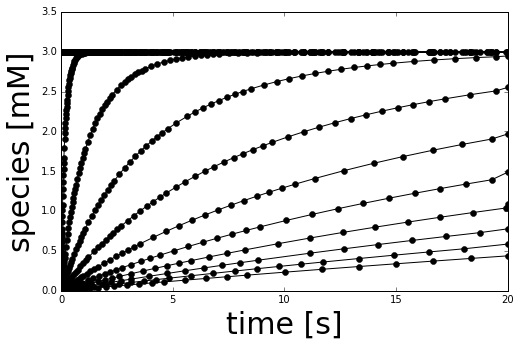

In [40]:
# make a concentration backup (needed later)
# [fix for roadrunner issue #250]
r.reset(SelectionRecord.ALL)
concentration_backup = dict()
for sid in r.model.getFloatingSpeciesIds():
    concentration_backup[sid] = r["[{}]".format(sid)]

# simulation
results = []
for k in xrange(Nsim):
    # change parameter
    r.x_cell = 10E-6 * (k+1) # [m]
    # update depending initial conditions (this should be rules!)
    r.reset(SelectionRecord.INITIAL_GLOBAL_PARAMETER)
    # restore initial concentrations under changed parameters
    for key, value in concentration_backup.iteritems():
        r.model['[{}]'.format(key)] = value
    # simulate
    s = r.simulate(0, tend)
    # store solution
    results.append(s)
    
# plot the results
plot_results(results)

## 3. Simulation of period of time, than change of parameter/boundary condition & continuation from the given concentrations
Different solutions possible. The complete simulation can be combined from partial simulations with copying the concentrations between end and start point of simulations.

Alternative option is adding events handling the change in paramter triggered by time into the SBML model. This changes the original model.

**Challenges**
* setting a non-boundary condition to a fixed value in the simulation. This requires changes in the underlying SBML model, namely fixing as a boundarySpecies and setting the value.
* setting a certain time course function for a given species. 

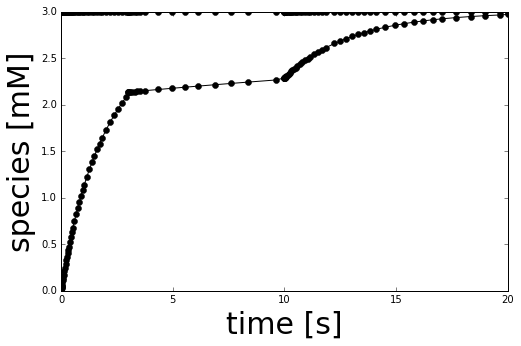

In [41]:
# Parameter/Concentration change for a certain amount of time.
def store_concentrations(r):
    """ Store FloatingSpecies concentrations of current model state. """
    c = dict()
    for sid in r.model.getFloatingSpeciesIds():
        c[sid] = r["[{}]".format(sid)]
    return c

def restore_concentrations(r, cdict):
    """ Restore the FloatingSpecies concentrations given in the dict. """
    for key, value in cdict.iteritems():
        r.model['[{}]'.format(key)] = value

# reset model
r.reset(SelectionRecord.ALL)

# storage for partial results
results = []
tends = [3, 10, 20]

# *** s1 ***
# simulate & store concentrations at end point
s1 = r.simulate(0, tends[0])
c1 = store_concentrations(r)
results.append(s1)

# *** s2 ***
# change parameters
x_cell = r.x_cell  # store old value
r.x_cell = 60E-6   # set new value
# update depending initial conditions (this should be rules!)
r.reset(SelectionRecord.INITIAL_GLOBAL_PARAMETER)
# set concentrations & simulate
restore_concentrations(r, c1)
s2 = r.simulate(tends[0], tends[1])
c2 = store_concentrations(r)
results.append(s2)

# *** s3 ***
r.x_cell = x_cell  # restore value
# update depending initial conditions
r.reset(SelectionRecord.INITIAL_GLOBAL_PARAMETER)
# set concentrations
restore_concentrations(r, c2)
s3 = r.simulate(tends[1], tends[2])
results.append(s3)
# print(results)

# concatenate results
import numpy as np
s = np.concatenate(results, axis=0)

# plot the results
plot_results([s])
# plot_results(results)
# print(results)   # [issue #257]

### boundaryConditions
Species values can easily be set to fixed values via the boundaryCondition flag.
In case of non-boundary conditions the boundaryConditions have to be set true first.

<Species c__gal "D-galactose">
<Species e__gal "D-galactose">
--------------------------------------------------------------------------------
*** Normal boundary conditions ***
['time', '[c__gal]', '[e__gal]']
<roadrunner.RoadRunner() { 
'this' : 0x5158e30
'modelLoaded' : true
'modelName' : test_4
'libSBMLVersion' : LibSBML Version: 5.11.0
'jacobianStepSize' : 1e-05
'conservedMoietyAnalysis' : false
'simulateOptions' : 
< roadrunner.SimulateOptions() 
{ 
'this' : 0x4605860, 
'reset' : 0,
'structuredResult' : 0,
'copyResult' : 1,
'steps' : 50,
'start' : 0,
'duration' : 5
}>, 
'integrator' : 
< roadrunner.Integrator() >
  settings:
      relative_tolerance: 0.000001
      absolute_tolerance: 1.5624999999999998e-20
                   stiff: true
       maximum_bdf_order: 5
     maximum_adams_order: 12
       maximum_num_steps: 20000
       maximum_time_step: 0
       minimum_time_step: 0
       initial_time_step: 0
          multiple_steps: false
      variable_step_size: true

}>
------

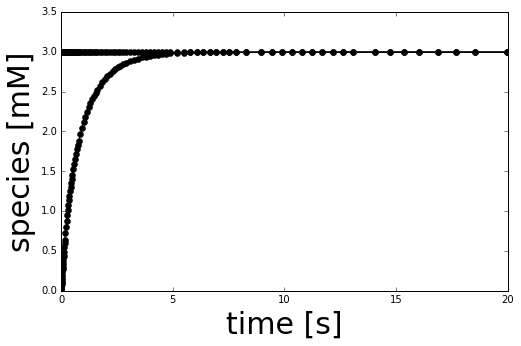

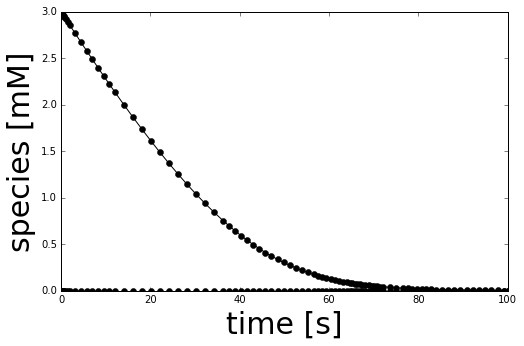

In [44]:
# ---------------------------------------
# SBML model modifications
# ---------------------------------------
model_id = 'test_4'
import libsbml
# get model
doc = libsbml.readSBML("{}.xml".format(model_id))
model = doc.getModel()
model.setId('{}_boundaryCondition'.format(model.getId()))

# get species
s_cgal = model.getSpecies("c__gal")
print(s_cgal)
s_egal = model.getSpecies("e__gal")
print(s_egal)

# Change the boundary conditions (True <-> False)
s_cgal.setBoundaryCondition(True)
s_egal.setBoundaryCondition(False)

libsbml.writeSBMLToFile(doc, '{}_boundaryCondition.xml'.format(model_id))


def set_settings(r):
    ''' 
    Sets all integrator settings in roadrunner.
    Necessary after every reload of models.
    '''
    # simulation settings
    absTol = 1E-6
    relTol = 1E-6
    # absTol relative to the amounts [fix for roadrunner issue #247]
    absTol = absTol * min(r.model.getCompartmentVolumes())  
    integrator = r.getIntegrator()
    integrator.setSetting('stiff', True)
    integrator.setSetting('absolute_tolerance', absTol)
    integrator.setSetting('relative_tolerance', relTol)
    integrator.setSetting('variable_step_size', True)
    

# ---------------------------------------
# Model simulations
# ---------------------------------------
import roadrunner
from roadrunner import SelectionRecord

print('-'*80)
print('*** Normal boundary conditions ***')
r = roadrunner.RoadRunner("{}.xml".format(model_id))
set_settings(r)
r.selections = ['time'] + \
        ['[{}]'.format(sid) for sid in r.model.getFloatingSpeciesIds()] + \
        ['[{}]'.format(sid) for sid in r.model.getBoundarySpeciesIds()]
print(r.selections)
print(r)
s1 = r.simulate(0,20)
plot_results([s1])

print('-'*80)
print('*** Altered boundary conditions ***')
r = roadrunner.RoadRunner("{}_boundaryCondition.xml".format(model_id))
set_settings(r)
r.selections = ['time'] + \
        ['[{}]'.format(sid) for sid in r.model.getFloatingSpeciesIds()] + \
        ['[{}]'.format(sid) for sid in r.model.getBoundarySpeciesIds()]
print(r.selections)
print(r)
s2 = r.simulate(0,100)
plot_results([s2])

In [43]:
### time varying species & parameters
The most complex simulation scenario is 

['e', 'm', 'c']
[  1.00000000e-12   1.00000000e+00   1.56250000e-14]
